## ProcessEmbeddings+FindMedianEmbeddingPerLSOA
This script:
- Loads sample points and their CLIP embeddings from the H5 data store
- Spatially joins points to LSOAs
- Expands so that each image (and associated embedding) is its own row, skipping missing images and NaN embeddings
- Removes some outlying images (_optional, currently disabled_):
    - This stage may not be necessary, but does effectively remove images of both inside of buildings and inside of cars.
    - This is based on using UMAP to reduce the dimensionality of embeddings to 2, and then plotting in 2-dimensional space.
    There are two very clearly separated clusters of points which when I looked at the images within them, were those inside the cars and inside the buildings
- Saves the expanded results for use in future scripts
- Finds the mean and median embedding per LSOA, and saves pickle files containing this information

In [1]:
import numpy as np
import pandas as pd
import h5py
import os
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt


In [2]:
from directory_filepaths import *

### Get spatial data

In [3]:
lsoas =  gpd.read_file(lsoas_file)
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
gm_lsoa=lsoas[lsoas['LSOA21NM'].str.contains(manc_lads_pattern)]
gm_lsoa = gm_lsoa.to_crs(epsg=4326)

### Get embeddings (four per location)

In [4]:
with h5py.File(h5_filename, "r") as f:
    point_ids = f["point_id"][:]
    latitudes = f["latitude"][:]
    longitudes = f["longitude"][:]
    embeddings = f["embeddings_clip"][:]        # (N, 4, 512)
    images_present = f["images_present"][:]     # (N, 4)
    image_paths = f["image_paths"][:]           # (N, 4)

print(f"Loaded {len(point_ids)} points from H5 store")

Loaded 18897 points from H5 store


### Join image embeddings points to gentrification LSOAs

In [5]:
points_df = pd.DataFrame({
    "point_id": point_ids,
    "latitude": latitudes,
    "longitude": longitudes,
})

point_coords = [Point(lon, lat) for lon, lat in zip(longitudes, latitudes)]
points_gdf = gpd.GeoDataFrame(points_df, geometry=point_coords, crs="EPSG:4326")

# Perform spatial join to get LSOA for each point
points_labels_gdf = gpd.sjoin(points_gdf, gm_lsoa, how='inner', predicate='within')

if 'index_right' in points_labels_gdf.columns:
    points_labels_gdf = points_labels_gdf.drop(columns=['index_right'])

print(f"Points after spatial join: {len(points_labels_gdf)} / {len(points_df)}"
      f" (some points may lie outside the label polygons and were dropped)")

Points after spatial join: 18897 / 18897 (some points may lie outside the label polygons and were dropped)


Check spatial join results by plotting points and LSOA boundaries together

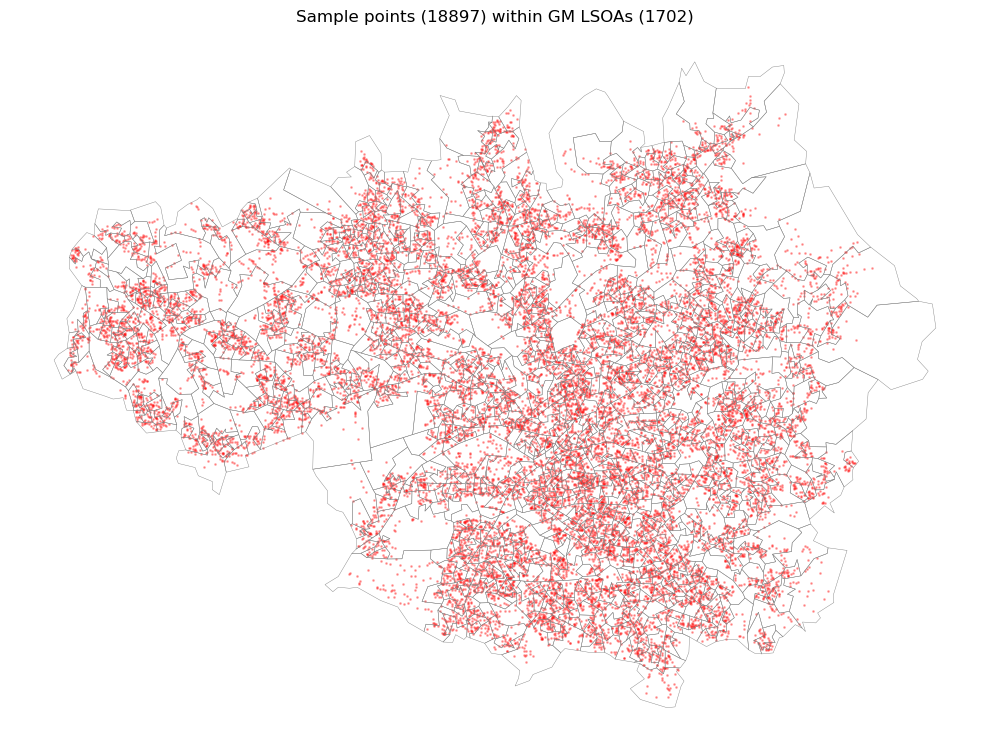

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gm_lsoa.boundary.plot(ax=ax, linewidth=0.3, color="grey")
points_labels_gdf.plot(ax=ax, markersize=1, color="red", alpha=0.3)
ax.set_title(f"Sample points ({len(points_labels_gdf)}) within GM LSOAs ({len(gm_lsoa)})")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Expand dataframe so there is one row per image

In [11]:
expanded_rows = []

for idx, row in points_labels_gdf.iterrows():
    # idx is the original index into the H5 arrays
    for j in range(4):
        if not images_present[idx, j]:
            continue
        emb = embeddings[idx, j, :]  # (512,)
        if np.all(np.isnan(emb)):
            continue

        new_row = row.to_dict()
        new_row['embedding'] = emb
        new_row['image_path'] = image_paths[idx, j].decode("ascii") if isinstance(image_paths[idx, j], bytes) else str(image_paths[idx, j])
        expanded_rows.append(new_row)

expanded_gdf = pd.DataFrame(expanded_rows)
print(f"Points with LSOA: {len(points_labels_gdf)}, Expanded rows (one per image): {len(expanded_gdf)}")

Points with LSOA: 18897, Expanded rows (one per image): 75586


In [12]:
expanded_gdf

,point_id,latitude,longitude,geometry,LSOA21CD,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,GlobalID,embedding,image_path
0,0,53.457824,-2.225911,POINT (-2.225911 53.457824),E01005284,Manchester 026C,None,385417,395474,53.4558,-2.22108,e00eadf6-8e6f-4526-bad4-e7cb06d3a61f,"[0.023864746, -0.05718994, -0.03366089, -0.009...",../data/airbnb-manchester/street_images/point0...
1,0,53.457824,-2.225911,POINT (-2.225911 53.457824),E01005284,Manchester 026C,None,385417,395474,53.4558,-2.22108,e00eadf6-8e6f-4526-bad4-e7cb06d3a61f,"[0.045318604, -0.06274414, -0.0107040405, -0.0...",../data/airbnb-manchester/street_images/point0...
2,0,53.457824,-2.225911,POINT (-2.225911 53.457824),E01005284,Manchester 026C,None,385417,395474,53.4558,-2.22108,e00eadf6-8e6f-4526-bad4-e7cb06d3a61f,"[0.049438477, -0.053375244, -0.0004746914, -0....",../data/airbnb-manchester/street_images/point0...
3,0,53.457824,-2.225911,POINT (-2.225911 53.457824),E01005284,Manchester 026C,None,385417,395474,53.4558,-2.22108,e00eadf6-8e6f-4526-bad4-e7cb06d3a61f,"[0.05657959, -0.06896973, 0.016143799, -0.0098...",../data/airbnb-manchester/street_images/point0...
4,1,53.457141,-2.049611,POINT (-2.049611 53.457141),E01006024,Tameside 022A,None,396885,394635,53.4485,-2.04837,d80e5056-8d39-4cf3-88eb-9d72ea0414be,"[0.012367249, -0.06137085, -0.042144775, 0.031...",../data/airbnb-manchester/street_images/point1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75581,19194,53.582965,-2.406821,POINT (-2.406821 53.582965),E01004931,Bolton 017E,None,372729,409583,53.5821,-2.41338,8c0fa890-ae8d-45a7-802e-693e225c4ab7,"[0.07104492, -0.053710938, 0.0014095306, 0.000...",../data/airbnb-manchester/street_images/point1...
75582,19195,53.389012,-2.284530,POINT (-2.28453 53.389012),E01005070,Manchester 051B,None,381015,388344,53.3916,-2.28694,21a49064-0bd5-48cc-ae6b-c4606fd36959,"[0.0395813, -0.070251465, -0.0042037964, -0.01...",../data/airbnb-manchester/street_images/point1...
75583,19195,53.389012,-2.284530,POINT (-2.28453 53.389012),E01005070,Manchester 051B,None,381015,388344,53.3916,-2.28694,21a49064-0bd5-48cc-ae6b-c4606fd36959,"[0.008338928, 0.00056648254, -0.007701874, 0.0...",../data/airbnb-manchester/street_images/point1...
75584,19195,53.389012,-2.284530,POINT (-2.28453 53.389012),E01005070,Manchester 051B,None,381015,388344,53.3916,-2.28694,21a49064-0bd5-48cc-ae6b-c4606fd36959,"[0.019622803, -0.080322266, -0.022842407, -0.0...",../data/airbnb-manchester/street_images/point1...


# Remove inside cars and inside buildings images
Decided this stage wasn't necessary, leaving code for reference

In [7]:
# # Example wrapper if you have a dataframe
# embeddings = np.vstack(expanded_gdf["embedding"].values)   # shape (N, 512)
#              # string labels
# reducer = umap.UMAP(
#     n_neighbors=30, 
#     min_dist=0.1, 
#     metric='cosine',   # ✔ recommended for CLIP embeddings
#     random_state=42)

# emb_2d = reducer.fit_transform(embeddings)  # shape (N, 2)

# expanded_gdf['umap_x'] = emb_2d[:, 0]
# expanded_gdf['umap_y'] = emb_2d[:, 1]

In [8]:
# # ---------------------------------------------------------
# # 2. Define MULTIPLE bounding boxes
# #    Format: (x_min, x_max, y_min, y_max)
# # ---------------------------------------------------------
# bounding_boxes = [(5.7, 6.3, 9.5, 10),     # Box 1
#                   (2.3, 3.2, 8.5,9)]

# # ---------------------------------------------------------
# # 3. Build mask for ANY point inside ANY box
# # ---------------------------------------------------------
# inside_any_box = np.zeros(len(expanded_gdf), dtype=bool)

# for (x_min, x_max, y_min, y_max) in bounding_boxes:
#     inside_this_box = (
#         (expanded_gdf["umap_x"] >= x_min) & (expanded_gdf["umap_x"] <= x_max) &
#         (expanded_gdf["umap_y"] >= y_min) & (expanded_gdf["umap_y"] <= y_max))
#     inside_any_box |= inside_this_box      # combine masks

# # ---------------------------------------------------------
# # 4. Remove all points inside any bounding box
# # ---------------------------------------------------------
# expanded_gdf_filtered = expanded_gdf[~inside_any_box].copy()

# # ---------------------------------------------------------
# # 5. Visual sanity check
# # ---------------------------------------------------------
# plt.figure(figsize=(4, 3))

# # Points kept
# plt.scatter(expanded_gdf_filtered["umap_x"], expanded_gdf_filtered["umap_y"], s=2, alpha=0.25, label="kept")

# # Points removed
# plt.scatter(expanded_gdf.loc[inside_any_box, "umap_x"], expanded_gdf.loc[inside_any_box, "umap_y"], s=10, color="red",
#             label="removed")

# # Draw rectangles on the plot
# ax = plt.gca()
# for (x_min, x_max, y_min, y_max) in bounding_boxes:
#     rect = plt.Rectangle((x_min, y_min),x_max - x_min,y_max - y_min,linewidth=2,edgecolor="black", facecolor="none")
#     ax.add_patch(rect)

# plt.legend()
# plt.title("UMAP with Multiple Removed Bounding Boxes")
# plt.tight_layout()
# plt.show()

# # (Optional) overwrite original:
# expanded_gdf = expanded_gdf_filtered.copy()

## Save results

In [ ]:
import os

one_row_per_image_path = os.path.join(data_dir, "one_row_per_image_cleaned.pkl")
os.makedirs(os.path.dirname(one_row_per_image_path), exist_ok=True)
expanded_gdf.to_pickle(one_row_per_image_path)

### Find mean and median embedding per LSOA and pickle them

In [14]:
# Keep only what we need for aggregation: LSOA21CD and embedding
cols_to_drop = [c for c in expanded_gdf.columns if c not in ('LSOA21CD', 'embedding')]
agg_df = expanded_gdf[['LSOA21CD', 'embedding']].copy()

In [15]:
def mean_embed(series):
    return np.mean(np.stack(series.values), axis=0)

def median_embed(series):
    return np.median(np.stack(series.values), axis=0)

emb_cat_mean = agg_df.groupby("LSOA21CD")["embedding"].apply(mean_embed).reset_index()
emb_cat_mean.rename(columns={"embedding": "mean_embedding"}, inplace=True)

emb_cat_median = agg_df.groupby("LSOA21CD")["embedding"].apply(median_embed).reset_index()
emb_cat_median.rename(columns={"embedding": "median_embedding"}, inplace=True)

In [18]:
summary_dir = os.path.join(data_dir, "per_lsoa_embedding_summaries")
os.makedirs(summary_dir, exist_ok=True)

emb_cat_mean.to_pickle(os.path.join(summary_dir, "mean_embedding.pkl"))
emb_cat_median.to_pickle(os.path.join(summary_dir, "median_embedding.pkl"))